https://colab.research.google.com/drive/1gt6x41vUIewXozVrrjQ1njGp2OqzarH-

In [0]:
!pip install PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_id = '0B-KJCaaF7elleG1RbzVPZWV4Tlk' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('steering_angle.zip')

In [0]:
!ls

adc.json  sample_data  steering_angle.zip


In [0]:
!pwd

/content


In [0]:
!unzip steering_angle.zip

In [0]:
!ls

adc.json  driving_dataset  __MACOSX  sample_data  steering_angle.zip


In [0]:
!pwd

/content


In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import pi
import cv2
import scipy.misc
import tensorflow as tf

In [0]:
DATA_FOLDER = "/content/driving_dataset/"
DATA_FILE = os.path.join(DATA_FOLDER, "data.txt")

x = []
y = []

train_batch_pointer = 0
test_batch_pointer = 0

In [0]:

with open(DATA_FILE) as f:
    for line in f:
        image_name, angle = line.split()
        
        image_path = os.path.join(DATA_FOLDER, image_name)
        x.append(image_path)
        
        angle_radians = float(angle) * (pi / 180)  #converting angle into radians
        y.append(angle_radians)
y = np.array(y)
print(str(len(x))+" "+str(len(y)))

45406 45406


In [0]:
x[2]

'/content/driving_dataset/2.jpg'

In [0]:
#x = x[1:]
print(str(len(x))+" "+str(len(y)))

45406 45406


In [0]:
split_ratio = int(len(x) * 0.8)

train_x = x[:split_ratio]
train_y = y[:split_ratio]

test_x = x[split_ratio:]
test_y = y[split_ratio:]

len(train_x), len(train_y), len(test_x), len(test_y)

(36324, 36324, 9082, 9082)

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


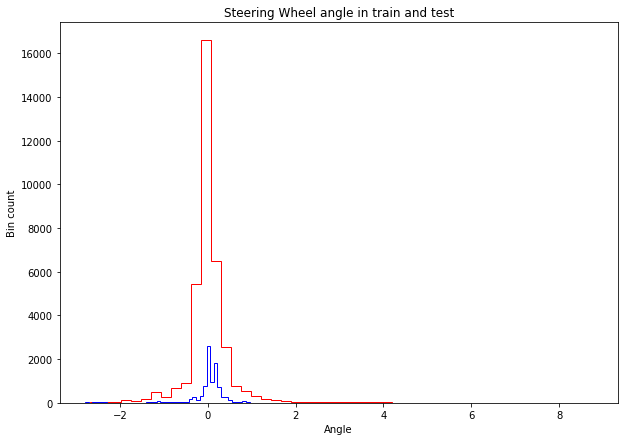

In [0]:
fig = plt.figure(figsize = (10, 7))
plt.hist(train_y, bins = 50, histtype = "step",color='r')
plt.hist(test_y, bins = 50, histtype = "step",color='b')
plt.title("Steering Wheel angle in train and test")
plt.xlabel("Angle")
plt.ylabel("Bin count")
plt.grid('off')
plt.show()

In [0]:
train_x[0]

'/content/driving_dataset/0.jpg'

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


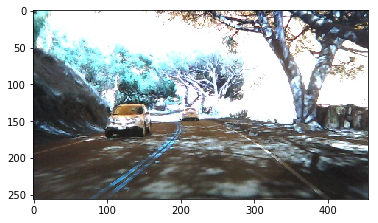

In [0]:
im = cv2.imread(train_x[30000])
plt.imshow(im)
plt.grid('off')

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


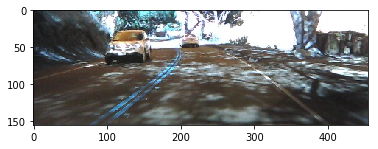

In [0]:
plt.imshow(im[100:,:,:])
plt.grid('off')

In [0]:
from keras.applications import vgg16
from keras.utils.vis_utils import plot_model
vgg16_model = vgg16.VGG16(include_top=False, weights='imagenet',input_shape=(156,455,3))

Using TensorFlow backend.



58892288/58889256 [==============================] - 6s 0us/step




In [0]:
x = []
y = []
for i in range(10000):
  if(i%1000==0):
    print(i)
  im = cv2.imread(train_x[i])
  im = im[100:,:,:]/255
  vgg_im = vgg16_model.predict(im.reshape(1,im.shape[0],im.shape[1],3))
  x.append(vgg_im)
  y.append(train_y[i])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [0]:
print(len(x),len(y))

10000 10000


In [0]:
x1 = np.array(x)
y1 = np.array(y)

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K

In [0]:
np.max(x1)

10.8959055

In [0]:
model = Sequential()
model.add(Flatten(input_shape=(4,14,512)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(100, activation='linear'))
model.add(Dropout(.2))
model.add(Dense(50, activation='linear'))
model.add(Dropout(.1))
model.add(Dense(10, activation='linear'))
model.add(Dense(1, activation='linear'))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 28672)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               14680576  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               51300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
___________________________

In [0]:
model.compile(loss='mean_squared_error',
              optimizer='adam')

In [0]:
x1.shape

(10000, 1, 4, 14, 512)

In [0]:
x1 = x1.reshape(x1.shape[0],4,14,512)

In [0]:
np.max(x1)

10.8959055

In [0]:
history = model.fit(x1/11, y1,batch_size=32,epochs=10, validation_split = 0.1, verbose = 1)

Instructions for updating:
Use tf.cast instead.
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 8s 925us/step - loss: 0.3527 - val_loss: 0.0655
Epoch 2/10
9000/9000 [==============================] - 7s 748us/step - loss: 0.2042 - val_loss: 0.0979
Epoch 3/10
9000/9000 [==============================] - 7s 751us/step - loss: 0.1929 - val_loss: 0.0678
Epoch 4/10
9000/9000 [==============================] - 7s 752us/step - loss: 0.1588 - val_loss: 0.0817
Epoch 5/10
9000/9000 [==============================] - 7s 750us/step - loss: 0.1754 - val_loss: 0.0733
Epoch 6/10
9000/9000 [==============================] - 7s 750us/step - loss: 0.1610 - val_loss: 0.0735
Epoch 7/10
9000/9000 [==============================] - 7s 746us/step - loss: 0.1588 - val_loss: 0.0738
Epoch 8/10
9000/9000 [==============================] - 7s 751us/step - loss: 0.1511 - val_loss: 0.0742
Epoch 9/10
9000/9000 [==============================] - 7s 753us/step - 

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


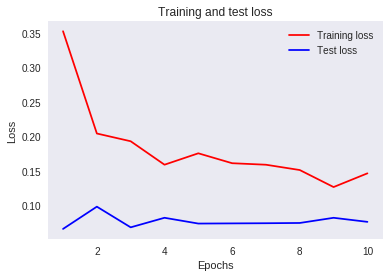

In [0]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(val_loss_values) + 1)
plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

In [0]:
k=-400
model.predict(x1[k].reshape(1,4,14,512)/11)

array([[0.02959396]], dtype=float32)

In [0]:
round(y1[k],2)

-0.17

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Text(0.5, 1.0, 'Predicted angle: 0.03, actual angle:-0.17')

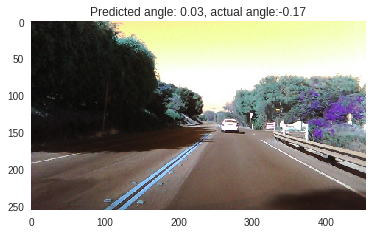

In [0]:
im = cv2.imread(train_x[k])
plt.imshow(im)
plt.grid('off')
plt.title('Predicted angle: {}, actual angle:{}'.format(str(round(model.predict(x1[k].reshape(1,4,14,512)/11)[0][0],2)), str(round(y1[k],2))))